In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from tqdm import tqdm

from src.UNET import UNet2D

In [6]:
def KLD(mu: torch.Tensor, log_var: torch.Tensor):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())


def BCE(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.binary_cross_entropy(recon, X, reduction='mean')


def L1Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.l1_loss(recon, X, reduction='mean')


def L2Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.mse_loss(recon, X, reduction='mean')

In [7]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas


num_steps = 1000
#betas = torch.tensor([1.7e-5] * num_steps)
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
alphas_bar_sqrt[-1] = 0
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
one_minus_alphas_bar_sqrt[-1] = 1


def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)


def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

In [8]:
BATCH_SIZE = 1024


class QX:
    def __init__(self, time_step=None):
        self.ts = time_step

    def __call__(self, sample):
        return q_x(sample, torch.tensor(self.ts))


transform = transforms.Compose([
    transforms.ToTensor(),
    QX([0, 10, 30, 100, 300, 600, 998, 999])
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)

(array([16.40702641,  0.40472741,  0.03113288,  0.21793014,  0.03113288,
         0.        ,  0.18679733,  0.12453151,  0.21793014,  0.06226575,
         0.06226575,  0.15566439,  0.09339863,  0.06226571,  0.1556645 ,
         0.28019569,  0.1245316 ,  0.09339856,  0.0622658 ,  0.21792998,
         0.1556645 ,  0.28019569,  0.1245316 ,  0.24906284,  4.60766921]),
 array([-0.0157075 ,  0.02526238,  0.06623226,  0.10720213,  0.14817201,
         0.18914188,  0.23011176,  0.27108163,  0.3120515 ,  0.35302138,
         0.39399126,  0.43496114,  0.47593102,  0.5169009 ,  0.55787081,
         0.59884065,  0.63981056,  0.68078041,  0.72175032,  0.76272017,
         0.80369008,  0.84465992,  0.88562983,  0.92659968,  0.96756959,
         1.00853944]),
 <BarContainer object of 25 artists>)

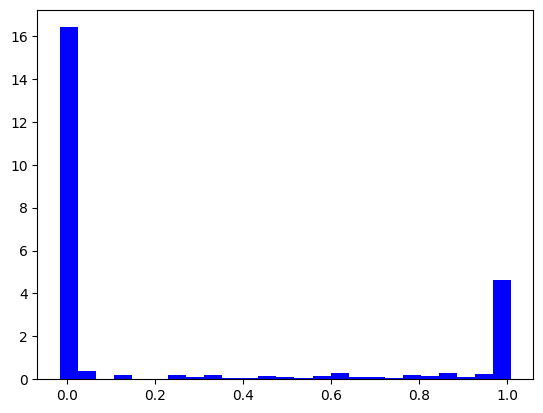

In [9]:
img0 = next(iter(train_loader))[0][0]
plt.hist(img0[0].flatten(), bins=25, density=True, color='b')

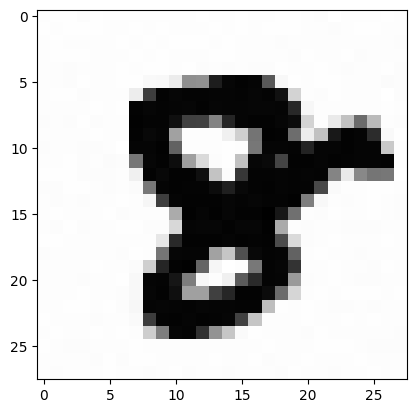

In [10]:
plt.imshow(img0[0], cmap='Greys')

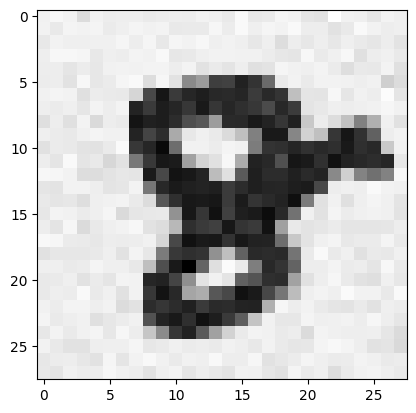

In [11]:
plt.imshow(img0[-5], cmap='Greys')

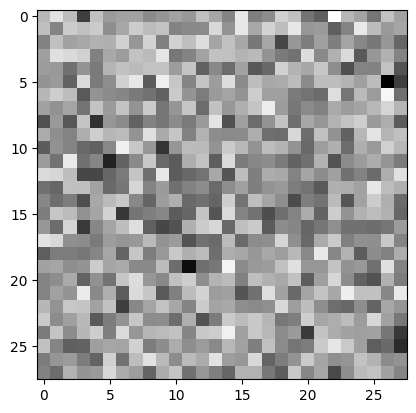

In [12]:
plt.imshow(img0[-1], cmap='Greys')

In [13]:
class TimestepLike(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size * 2)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.hiddenSize = hidden_size

    def forward(self, X):
        h0 = self.encoder(X)
        h1, h2 = torch.chunk(h0, 2, dim=-1)
        h = torch.mul(h1, torch.softmax(h2, dim=-1))
        return self.decoder(nn.functional.leaky_relu(h))


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.h = TimestepLike(28 * 28, 256)
        self.mu = TimestepLike(256, 28 * 28)
        self.var = TimestepLike(256, 28 * 28)
        self.decoder = nn.Sequential(nn.Linear(28 * 28, 256),
                                     nn.LeakyReLU(),
                                     nn.Linear(256, 28 * 28))

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, X):
        h = self.h(X)
        mu = self.mu(h)
        var = self.var(h)
        return self.decoder(self.reparameterize(mu, var))


class MultiUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.f0 = UNet2D(1, 1)
        self.f1 = UNet2D(1, 1)
        self.f2 = UNet2D(1, 1)
        self.f3 = UNet2D(1, 1)

    def forward(self, X):
        h0 = self.f0(X)
        h1 = self.f1(h0)
        h2 = self.f2(h1)
        h3 = self.f2(h2)

        return h0, h1, h2, h3

In [29]:
# model = nn.Sequential(nn.Linear(28 * 28, 8 * 28),
#                       nn.ReLU(),
#                       # nn.Linear(256, 128),
#                       # nn.ReLU(),
#                       # nn.Linear(128, 256),
#                       # nn.ReLU(),
#                       nn.Linear(8 * 28, 28 * 28)).to('cuda')
# model = nn.Linear(28 * 28, 28 * 28).to('cuda')
model = MultiUNet().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [30]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            X = data[:, -1].to('cuda').view(-1, 1, 28, 28)
            Y3 = data[:, -2].to('cuda').view(-1, 1, 28, 28)
            Y2 = data[:, -3].to('cuda').view(-1, 1, 28, 28)
            Y1 = data[:, -4].to('cuda').view(-1, 1, 28, 28)
            Y0 = data[:, -5].to('cuda').view(-1, 1, 28, 28)
            optimizer.zero_grad()
            output = model(X)
            loss = L2Loss(output[0], Y0) + L2Loss(output[1], Y1) + L2Loss(output[2], Y2) + L2Loss(output[3], Y3)
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tLoss: {:.8f}\t lr: {:.8f}'.format(
                epoch, loss.item(), optimizer.param_groups[0]['lr']))
    return allLoss

In [37]:
for epoch in range(1, 1001):
    loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

 88%|████████▊ | 52/59 [00:52<00:07,  1.01s/batch,  Epoch: 7 	Loss: 0.18799943	 lr: 0.00100000]


KeyboardInterrupt: 

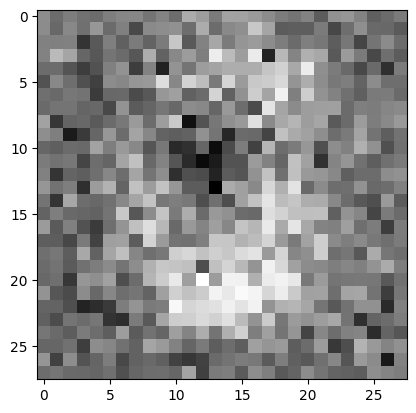

In [64]:
img0 = next(iter(train_loader))[0][0]
y = model(img0.to('cuda').view(-1, 1, 28, 28))
plt.imshow(-1*y[0][-1].cpu().detach().view(28, 28), cmap='Greys')

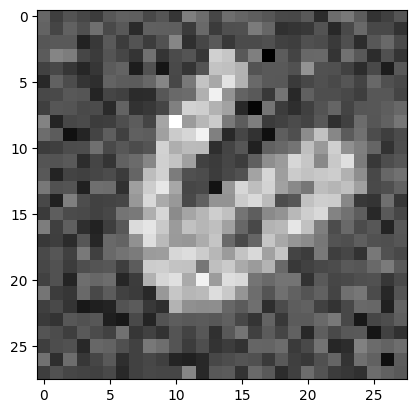

In [65]:
plt.imshow((img0[-4]).view(28, 28), cmap='gray')

(array([0.00826888, 0.02480665, 0.08268891, 0.1074955 , 0.19845324,
        0.23152887, 0.30594874, 0.71112437, 0.62016648, 0.50440203,
        0.68631758, 0.57882205, 0.64497314, 0.55401534, 0.35556212,
        0.26460442, 0.26460432, 0.13230221, 0.08268888, 0.05788219,
        0.03307554, 0.01653777, 0.00826889, 0.        , 0.00826888]),
 array([-1.78802872, -1.63377452, -1.47952032, -1.32526624, -1.17101204,
        -1.01675785, -0.86250371, -0.70824951, -0.55399537, -0.3997412 ,
        -0.24548702, -0.09123285,  0.06302132,  0.21727549,  0.37152967,
         0.52578384,  0.68003798,  0.83429217,  0.98854631,  1.14280045,
         1.29705465,  1.45130885,  1.60556304,  1.75981712,  1.91407132,
         2.06832552]),
 <BarContainer object of 25 artists>)

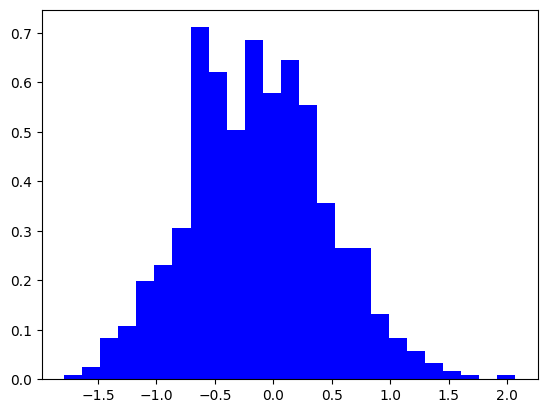

In [54]:
plt.hist((y[-1].cpu().detach().view(28, 28) - img0[-2]).flatten(), bins=25, density=True, color='b')

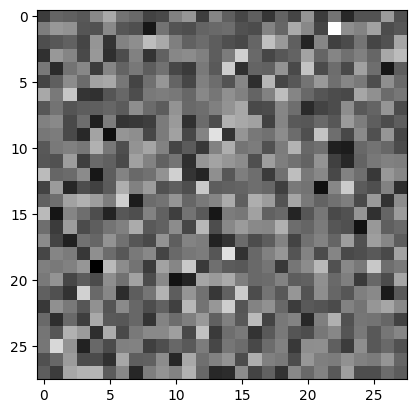

In [55]:
plt.imshow((y[-1].cpu().detach().view(28, 28) - img0[-1]).view(28, 28), cmap='gray')